In [1]:
import sys,os
sys.path.append('..')
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.swarms.swarm import Swarm
from backtester.exoinfo import EXOInfo
from exobuilder.data.exostorage import EXOStorage
from IPython.core.display import display, HTML

from sklearn import linear_model, cross_validation, naive_bayes, ensemble, tree, neighbors, cluster, preprocessing

import pandas as pd
import numpy as np
import scipy
import pprint

import glob
from pandas.tseries.offsets import *

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

figsize(20,10)

Populating the interactive namespace from numpy and matplotlib


# Saved Swarm universes as input

In [219]:
df = pd.DataFrame()
exoname = 'CL'
direction = '' # Long short
alphastrategy = 'IchimokuCloud' # CallSpread .. etc

for file in glob.glob("../swarms/*.swm"):
    swarmname = file.split('/')[-1]
    
    if (exoname in swarmname) and (direction in swarmname) and (alphastrategy in swarmname):
        if df.size == 0:
            df = Swarm.load('../swarms/'+swarmname).raw_swarm
        else:
            df = pd.concat([df, Swarm.load('../swarms/'+swarmname).raw_swarm], axis=1)
    #print(file.split('/')[-1])
    #break
    
df = df.dropna(how='all')

## Single swarm

In [94]:
# set file name here
swarm_file = 'ZS_CallSpread_Short_IchimokuCloud'

# Real swarm from .swm
df = Swarm.load('../swarms/'+swarm_file+'.swm').raw_swarm
#df = df

## Systems overall performance estimation

In [95]:
temp_l = []

for strat in df.columns:

        input_strategy_data = df[strat] # This data is used in metrics calc

        price_change = input_strategy_data.diff()
        max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
        netprofit = df[strat].ix[-1] - df[strat].ix[0]

        # Since swarm PnL statistics is not trade-by-trade
        # For PF calc I used cumulative values of positive and negatives price changes
        # Same for winrate
        profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())

        winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               

        try:
            modsharpe = np.mean(price_change) / np.std(price_change)

        except ZeroDivisionError:
            modsharpe = np.nan

        d = {'strategy': strat,
            'stats_pricechange_modsharpe': modsharpe, 
            'stats_netprofit': netprofit,
            'stats_max_dd': max_dd, 'stats_recovery_factor': netprofit / np.abs(max_dd),
            'stats_profit_factor': profit_factor, 'stats_winrate': winrate }

        temp_l.append(d)

In [96]:
strategies_performance_df = pd.DataFrame(temp_l).dropna()
strategies_performance_df['rank_score'] = np.zeros_like(len(strategies_performance_df))

In [97]:
ranks_d = {}

for col in strategies_performance_df.columns:
    
    stats_col_flag = False
    
    if 'stats' in col:

        # Define 0-10-20-30-40-50-60-70-80-90-100 quantiles values of certain strategy statistics
        metric_quantile0 = strategies_performance_df[col].quantile(0.0)
        metric_quantile10 = strategies_performance_df[col].quantile(0.1)
        metric_quantile20 = strategies_performance_df[col].quantile(0.2)
        metric_quantile30 = strategies_performance_df[col].quantile(0.3)
        metric_quantile40 = strategies_performance_df[col].quantile(0.4)
        metric_quantile50 = strategies_performance_df[col].quantile(0.5)
        metric_quantile60 = strategies_performance_df[col].quantile(0.6)
        metric_quantile70 = strategies_performance_df[col].quantile(0.7)
        metric_quantile80 = strategies_performance_df[col].quantile(0.8)
        metric_quantile90 = strategies_performance_df[col].quantile(0.9)
        metric_quantile100 = strategies_performance_df[col].quantile(1)
        
        stats_col_flag = True
    
    if stats_col_flag == True:
        
        for strat in strategies_performance_df.strategy:
        
            # Define strategy statistics rank of certain strategy

            strategy_stats_metric = strategies_performance_df[strategies_performance_df.strategy == strat][col].values[0]

            if strategy_stats_metric >= metric_quantile0 and strategy_stats_metric <= metric_quantile10:
                rank_score = 0

            elif strategy_stats_metric >= metric_quantile10 and strategy_stats_metric <= metric_quantile20:
                rank_score = 1

            elif strategy_stats_metric >= metric_quantile20 and strategy_stats_metric <= metric_quantile30:
                rank_score = 2

            elif strategy_stats_metric >= metric_quantile30 and strategy_stats_metric <= metric_quantile40:
                rank_score = 3

            elif strategy_stats_metric >= metric_quantile40 and strategy_stats_metric <= metric_quantile50:
                rank_score = 4

            elif strategy_stats_metric >= metric_quantile50 and strategy_stats_metric <= metric_quantile60:
                rank_score = 5

            elif strategy_stats_metric >= metric_quantile60 and strategy_stats_metric <= metric_quantile70:
                rank_score = 6

            elif strategy_stats_metric >= metric_quantile70 and strategy_stats_metric <= metric_quantile80:
                rank_score = 7

            elif strategy_stats_metric >= metric_quantile80 and strategy_stats_metric <= metric_quantile90:
                rank_score = 8

            elif strategy_stats_metric >= metric_quantile90 and strategy_stats_metric <= metric_quantile100:
                rank_score = 9

            elif strategy_stats_metric == metric_quantile100:
                rank_score = 10

                
            if strat not in ranks_d.keys():               
                ranks_d[strat] = rank_score
                
            elif strat in ranks_d.keys():                
                ranks_d[strat] = ranks_d[strat] + rank_score
                          
            # For debugging purposes

            #print('strategy---',strat,'\n')
            #print(col)
            #print('10 quantile---',metric_quantile10)
            #print(strategy_stats_metric)
            #print('60 quantile---',metric_quantile60)
            #print(strategy_stats_metric > metric_quantile40 and strategy_stats_metric < metric_quantile50)
            #print('rank_score------', rank_score, '\n')

        #print("NEXT----------------------- \n")

# Set rank scores for strategies from dict

for k in ranks_d:
    
    strat_index = strategies_performance_df[strategies_performance_df.strategy == k].index
    strategies_performance_df = strategies_performance_df.set_value(strat_index, 'rank_score', ranks_d[k])

In [98]:
strategies_performance_df.sort_values('rank_score', ascending=False)

,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy,rank_score
145,-5990.700846,10846.597817,0.027942,1.127468,1.810572,33.401639,"(-1, 5, 26, 13, 52, 5, 15)",50
144,-7044.219046,11482.695185,0.028860,1.125181,1.630088,35.553279,"(-1, 5, 26, 13, 52, 4, 5)",50
64,-3369.327644,12590.966530,0.038440,1.201743,3.736937,27.254098,"(-1, 10, 26, 13, 52, 5, 5)",49
149,-3369.327644,12379.991408,0.037599,1.197716,3.674321,27.254098,"(-1, 5, 26, 13, 52, 5, 5)",49
155,-4256.013546,8842.356935,0.030981,1.177846,2.077615,21.670082,"(-1, 5, 26, 13, 52, 7, 15)",46
104,-6373.449648,9550.552907,0.023272,1.102046,1.498490,32.274590,"(-1, 5, 26, 13, 52, 11, 5)",46
84,-3236.559243,12037.512156,0.049365,1.369633,3.719231,14.959016,"(-1, 10, 26, 13, 52, 9, 5)",46
59,-7860.230200,10250.749821,0.025863,1.112131,1.304128,35.194672,"(-1, 10, 26, 13, 52, 4, 5)",46
169,-3236.559243,12037.512156,0.049365,1.369633,3.719231,14.959016,"(-1, 5, 26, 13, 52, 9, 5)",46
146,-6384.439680,10081.769811,0.027382,1.126277,1.579116,31.250000,"(-1, 5, 26, 13, 52, 5, 25)",46


In [99]:
members_names = strategies_performance_df.strategy.str.replace(')','').str.replace('(','').str.split(',')

parameters_cols = []
for p in range(len(members_names[0])):
    parameters_cols.append('param'+str(p))
    
#parameters_df = pd.DataFrame(columns=parameters_cols, index=members_names.index)
parameters_df = pd.DataFrame().from_records(list(members_names.values)).convert_objects(convert_numeric=True)
parameters_df.columns = parameters_cols
parameters_df['rank_score'] = strategies_performance_df.rank_score
parameters_df = parameters_df.drop('param0',1).dropna()

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:8: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [100]:
parameters_df.sort_values('rank_score', ascending=False)

,param1,param2,param3,param4,param5,param6,rank_score
145,5,26,13,52,5,15,50
144,5,26,13,52,4,5,50
64,10,26,13,52,5,5,49
149,5,26,13,52,5,5,49
155,5,26,13,52,7,15,46
104,5,26,13,52,11,5,46
84,10,26,13,52,9,5,46
59,10,26,13,52,4,5,46
169,5,26,13,52,9,5,46
146,5,26,13,52,5,25,46


In [101]:
best_members = parameters_df[parameters_df.rank_score >= parameters_df.rank_score.quantile(0.9)]

best_members.param1.value_counts(normalize=True)

5     0.647059
10    0.352941
Name: param1, dtype: float64

In [102]:
best_members.param2.value_counts(normalize=True)

26    1.0
Name: param2, dtype: float64

In [103]:
best_members.param3.value_counts(normalize=True)

13    1.0
Name: param3, dtype: float64

In [104]:
best_members.param4.value_counts(normalize=True)

52    1.0
Name: param4, dtype: float64

In [105]:
best_members.param5.value_counts(normalize=True)

9     0.235294
7     0.235294
5     0.235294
4     0.117647
11    0.058824
10    0.058824
8     0.058824
Name: param5, dtype: float64

In [106]:
best_members.param6.value_counts(normalize=True)

5     0.647059
15    0.294118
25    0.058824
Name: param6, dtype: float64

# .
# Do a same thing as regular ranking procedure
# .

In [229]:
temp_l = []

for strat in df.columns:

        input_strategy_data = df[strat] # This data is used in metrics calc

        price_change = input_strategy_data.diff()
        max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
        netprofit = df[strat].ix[-1] - df[strat].ix[0]

        # Since swarm PnL statistics is not trade-by-trade
        # For PF calc I used cumulative values of positive and negatives price changes
        # Same for winrate
        profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())

        winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               

        try:
            modsharpe = np.mean(price_change) / np.std(price_change)

        except ZeroDivisionError:
            modsharpe = np.nan

        try:
            d = {'strategy': strat,
                'stats_pricechange_modsharpe': modsharpe.values[0],
                'stats_netprofit': netprofit.values[0],
                'stats_max_dd': max_dd.values[0], 
                'stats_recovery_factor': (netprofit / np.abs(max_dd)).values[0],
                'stats_profit_factor': (profit_factor).values[0]
                 }

            temp_l.append(d)
        
        except:
            d = {'strategy': strat,
                'stats_pricechange_modsharpe': modsharpe,
                'stats_netprofit': netprofit,
                'stats_max_dd': max_dd, 
                'stats_recovery_factor': (netprofit / np.abs(max_dd)),
                'stats_profit_factor': (profit_factor)
                 }

            temp_l.append(d)

        temp_l.append(d)

In [230]:
strategies_performance_df = pd.DataFrame(temp_l).dropna()
strategies_performance_df['rank_score'] = np.zeros_like(len(strategies_performance_df))

In [231]:
strategies_performance_df 

,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,strategy,rank_score
0,-914.465290,2734.239561,0.033553,1.614114,2.989987,"(-1, 4, 10, 0.05, 1, 1, 30)",0
1,-914.465290,2734.239561,0.033553,1.614114,2.989987,"(-1, 4, 10, 0.05, 1, 1, 30)",0
2,-1622.030857,5332.151074,0.049489,1.592558,3.287330,"(-1, 5, 10, 0.05, 1, 0, 30)",0
3,-1622.030857,5332.151074,0.049489,1.592558,3.287330,"(-1, 5, 10, 0.05, 1, 0, 30)",0
4,-82.999670,243.689300,0.035074,2.028961,2.936027,"(-1, 5, 10, 0.05, 1, 3, 30)",0
5,-82.999670,243.689300,0.035074,2.028961,2.936027,"(-1, 5, 10, 0.05, 1, 3, 30)",0
6,-3698.800561,11839.623115,0.040944,1.205216,3.200936,"(-1, 2, 12, 2, 16)",0
7,-3698.800561,11839.623115,0.040944,1.205216,3.200936,"(-1, 2, 12, 2, 16)",0
8,-4032.393884,12439.546103,0.043334,1.218137,3.084904,"(-1, 2, 12, 2, 18)",0
9,-4032.393884,12439.546103,0.043334,1.218137,3.084904,"(-1, 2, 12, 2, 18)",0


In [232]:
ranks_d = {}

for col in strategies_performance_df.columns:
    
    stats_col_flag = False
    
    if 'stats' in col:

        # Define 0-10-20-30-40-50-60-70-80-90-100 quantiles values of certain strategy statistics
        metric_quantile0 = strategies_performance_df[col].quantile(0.0)
        metric_quantile10 = strategies_performance_df[col].quantile(0.1)
        metric_quantile20 = strategies_performance_df[col].quantile(0.2)
        metric_quantile30 = strategies_performance_df[col].quantile(0.3)
        metric_quantile40 = strategies_performance_df[col].quantile(0.4)
        metric_quantile50 = strategies_performance_df[col].quantile(0.5)
        metric_quantile60 = strategies_performance_df[col].quantile(0.6)
        metric_quantile70 = strategies_performance_df[col].quantile(0.7)
        metric_quantile80 = strategies_performance_df[col].quantile(0.8)
        metric_quantile90 = strategies_performance_df[col].quantile(0.9)
        metric_quantile100 = strategies_performance_df[col].quantile(1)
        
        stats_col_flag = True
    
    if stats_col_flag == True:
        
        for strat in strategies_performance_df.strategy:
        
            # Define strategy statistics rank of certain strategy

            strategy_stats_metric = strategies_performance_df[strategies_performance_df.strategy == strat][col].values[0]

            if strategy_stats_metric >= metric_quantile0 and strategy_stats_metric <= metric_quantile10:
                rank_score = 0

            elif strategy_stats_metric >= metric_quantile10 and strategy_stats_metric <= metric_quantile20:
                rank_score = 1

            elif strategy_stats_metric >= metric_quantile20 and strategy_stats_metric <= metric_quantile30:
                rank_score = 2

            elif strategy_stats_metric >= metric_quantile30 and strategy_stats_metric <= metric_quantile40:
                rank_score = 3

            elif strategy_stats_metric >= metric_quantile40 and strategy_stats_metric <= metric_quantile50:
                rank_score = 4

            elif strategy_stats_metric >= metric_quantile50 and strategy_stats_metric <= metric_quantile60:
                rank_score = 5

            elif strategy_stats_metric >= metric_quantile60 and strategy_stats_metric <= metric_quantile70:
                rank_score = 6

            elif strategy_stats_metric >= metric_quantile70 and strategy_stats_metric <= metric_quantile80:
                rank_score = 7

            elif strategy_stats_metric >= metric_quantile80 and strategy_stats_metric <= metric_quantile90:
                rank_score = 8

            elif strategy_stats_metric >= metric_quantile90 and strategy_stats_metric <= metric_quantile100:
                rank_score = 9

            elif strategy_stats_metric == metric_quantile100:
                rank_score = 10

                
            if strat not in ranks_d.keys():               
                ranks_d[strat] = rank_score
                
            elif strat in ranks_d.keys():                
                ranks_d[strat] = ranks_d[strat] + rank_score
                          
            # For debugging purposes

            #print('strategy---',strat,'\n')
            #print(col)
            #print('10 quantile---',metric_quantile10)
            #print(strategy_stats_metric)
            #print('60 quantile---',metric_quantile60)
            #print(strategy_stats_metric > metric_quantile40 and strategy_stats_metric < metric_quantile50)
            #print('rank_score------', rank_score, '\n')

        #print("NEXT----------------------- \n")

# Set rank scores for strategies from dict

for k in ranks_d:
    
    strat_index = strategies_performance_df[strategies_performance_df.strategy == k].index
    strategies_performance_df = strategies_performance_df.set_value(strat_index, 'rank_score', ranks_d[k])

In [239]:
strategies_performance_df.sort_values('rank_score', ascending=False).head(10)

,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,rank_score
strategy,,,,,,
"(-1, 8, 9, 20)",-3686.687963,14353.139926,0.051893,1.331622,3.893234,192
"(-1, 110, 25, 2, 20)",-3288.493154,21043.079493,0.075109,1.409760,6.399004,86
"(-1, 110, 90, 2, 20)",-3288.493154,21043.079493,0.075109,1.409760,6.399004,86
"(-1, 110, 55, 2, 20)",-3288.493154,21043.079493,0.075109,1.409760,6.399004,86
"(-1, 110, 15, 2, 20)",-3288.493154,21043.079493,0.075109,1.409760,6.399004,86
"(-1, 110, 30, 2, 20)",-3288.493154,21043.079493,0.075109,1.409760,6.399004,86
"(-1, 110, 35, 2, 20)",-3288.493154,21043.079493,0.075109,1.409760,6.399004,86
"(-1, 110, 45, 2, 20)",-3288.493154,21043.079493,0.075109,1.409760,6.399004,86
"(-1, 7, 2, 20)",-3345.787647,24371.268905,0.074173,1.327710,7.284165,86


## Filter those strategies by correlation

In [241]:
# Rearrange columns from best to worst strategies
strategies_performance_df.set_index('strategy', inplace=True)
strategies_performance_df = strategies_performance_df.index.drop_duplicates()

df = df.reindex_axis(strategies_performance_df.sort_values('rank_score', ascending=False).index, axis=1)

ValueError: cannot reindex from a duplicate axis

In [161]:
df.corr()

,"(-1, 4, 10, 0.05, 1, 1, 30)","(-1, 5, 10, 0.05, 1, 0, 30)","(-1, 5, 10, 0.05, 1, 3, 30)","(-1, 2, 12, 2, 16)","(-1, 2, 12, 2, 18)","(-1, 3, 12, 2, 16)","(-1, 3, 12, 2, 18)","(-1, 4, 12, 2, 18)","(-1, 5, 12, 2, 16)","(-1, 5, 12, 2, 18)",...,"(-1, 90, 13, 26, 10, 13, 20)","(-1, 90, 13, 26, 10, 16, 20)","(-1, 90, 13, 26, 10, 2, 20)","(-1, 90, 13, 26, 10, 2, 30)","(-1, 90, 13, 26, 10, 3, 20)","(-1, 90, 13, 26, 10, 3, 30)","(-1, 90, 13, 26, 10, 4, 20)","(-1, 90, 13, 26, 10, 5, 20)","(-1, 90, 13, 26, 10, 6, 20)","(-1, 90, 13, 26, 10, 8, 20)"
"(-1, 4, 10, 0.05, 1, 1, 30)",1.000000,0.849720,0.167038,0.956274,0.932535,0.955831,0.943798,0.929307,0.907097,0.923439,...,0.841038,0.914739,0.955390,0.947416,0.938902,0.916078,0.851248,0.863597,0.876115,0.922507
"(-1, 5, 10, 0.05, 1, 0, 30)",0.849720,1.000000,0.280599,0.808194,0.794053,0.866524,0.856127,0.831989,0.809896,0.815598,...,0.841680,0.747143,0.874975,0.893661,0.851629,0.844383,0.781767,0.763018,0.772543,0.806116
"(-1, 5, 10, 0.05, 1, 3, 30)",0.167038,0.280599,1.000000,0.162061,0.152482,0.207762,0.192139,0.175123,0.150790,0.152678,...,0.200481,0.092241,0.199738,0.231851,0.196901,0.197761,0.168011,0.140990,0.152144,0.162519
"(-1, 2, 12, 2, 16)",0.956274,0.808194,0.162061,1.000000,0.987665,0.981138,0.983429,0.979542,0.960651,0.976267,...,0.903501,0.957434,0.983763,0.974101,0.983300,0.964535,0.942497,0.936261,0.923527,0.975166
"(-1, 2, 12, 2, 18)",0.932535,0.794053,0.152482,0.987665,1.000000,0.965600,0.988581,0.988084,0.946903,0.979276,...,0.913364,0.956939,0.979058,0.966349,0.983497,0.964415,0.954997,0.942336,0.919931,0.983195
"(-1, 3, 12, 2, 16)",0.955831,0.866524,0.207762,0.981138,0.965600,1.000000,0.987750,0.974944,0.955331,0.966550,...,0.900094,0.924285,0.982149,0.980056,0.972358,0.962918,0.923406,0.928136,0.922614,0.951011
"(-1, 3, 12, 2, 18)",0.943798,0.856127,0.192139,0.983429,0.988581,0.987750,1.000000,0.993224,0.954802,0.981653,...,0.923675,0.942017,0.989725,0.982992,0.988097,0.973340,0.950037,0.941583,0.927745,0.975983
"(-1, 4, 12, 2, 18)",0.929307,0.831989,0.175123,0.979542,0.988084,0.974944,0.993224,1.000000,0.964148,0.989534,...,0.934544,0.959253,0.984019,0.973539,0.989374,0.975133,0.955693,0.945893,0.934592,0.985584
"(-1, 5, 12, 2, 16)",0.907097,0.809896,0.150790,0.960651,0.946903,0.955331,0.954802,0.964148,1.000000,0.988807,...,0.928603,0.959279,0.968508,0.952865,0.963675,0.965042,0.950792,0.968374,0.969847,0.963417
"(-1, 5, 12, 2, 18)",0.923439,0.815598,0.152678,0.976267,0.979276,0.966550,0.981653,0.989534,0.988807,1.000000,...,0.938396,0.971379,0.983823,0.968041,0.984254,0.977516,0.964843,0.970646,0.963577,0.985262


In [ ]:
corr_df = df.corr()

while_loop_break_flag = False

while True:   
    if while_loop_break_flag == False:
        
        for i in range(len(corr_df)):

            try:       
                strat_corr = corr_df[corr_df.columns[i]]
            
            except IndexError:               
                strat_corr = corr_df[corr_df.columns[-1]]
            
            df = df.drop(strat_corr[(strat_corr.index != strat_corr.name) & (strat_corr >= 0.9)].index, axis=1)

            # Check if previous DF are the same as current DF
            # If they are different - continue the loop

            df_comparison_array = np.array_equal(corr_df,df.corr())
            
            #print(strat_corr[(strat_corr.index != strat_corr.name) & (strat_corr >= 0.5)].index)
            #print(i)
            #print(len(corr_df))
            #print(len(corr_df))
            
            if df_comparison_array  == False and i < len(corr_df):
                corr_df = df.corr()

            elif df_comparison_array  == True and i == len(corr_df)-1:
                while_loop_break_flag = True
                break
                    
    if while_loop_break_flag == True:
        break

In [ ]:
df.corr()

In [ ]:
df.dropna().plot(legend=False)

# Metrics calculation

In [ ]:
#
# Rebalance triggers
#
# Rebalance trigger must be array of Datetime indexes when event occurred, like date of monday or new month
# 
newmonth = df[df.index.month != df.index.shift(1).month].index

monday = df[df.index.weekday == 0].index

norebalance = [df.index[-1]]

newyear = df[df.index.year != df.index.shift(1).year].index
#
#
#

# note: I think more performance metrics for strategies is better
# https://www.amibroker.com/guide/h_report.html for reference

rebalance_index = 1
rebalance_date_start = None

rebalance_trigger = monday # set rebalance trigger here

temp_l = []

for reb_idx in rebalance_trigger:
    
    for strat in df.columns:

        if rebalance_index == 1:
            rebalance_date_start = df.index[0]
           
        for i in range(len(df[strat])):

            if df[strat].index[i] == reb_idx:

                input_strategy_data = df[strat].ix[rebalance_date_start:reb_idx] # This data is used in metrics calc
                
                price_change = input_strategy_data.diff()
                max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
                netprofit = df[strat].ix[reb_idx] - df[strat].ix[rebalance_date_start]
                
                # Since swarm PnL statistics is not trade-by-trade
                # For PF calc I used cumulative values of positive and negatives price changes
                # Same for winrate
                profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())
                
                winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               
                # If all trades are negative, PF is 0. But later all 0s is replaced with NaN. 
                # To avoid replacing true 0.0 PF set it to 0.000001
                # This made for handling missing data 
                
                # Also winrate can be 0.0, but if PF is NaN - no trades were made
                # This made for handling missing data 
                
                if winrate == 0.0 and np.isnan(profit_factor) == False:
                    winrate = 0.000001
                
                elif winrate == 0.0 and np.isnan(profit_factor) == True:
                    winrate = np.nan
                                
                if profit_factor == 0.0:
                    profit_factor = 0.000001                
                          
                try:
                    modsharpe = np.mean(price_change) / np.std(price_change)
                    
                except ZeroDivisionError:
                    modsharpe = np.nan
            
                
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'stats_pricechange_modsharpe': modsharpe, 
                    'stats_netprofit': netprofit,
                    'stats_max_dd': max_dd, 'stats_recovery_factor': netprofit / np.abs(max_dd),
                    'stats_profit_factor': profit_factor, 'stats_winrate': winrate, 
                     'equity_below_zero': df[strat].ix[rebalance_date_start] < 0}
                
                '''
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'stats_pricechange_modsharpe': modsharpe, 
                    'stats_recovery_factor': netprofit / np.abs(max_dd)}
                '''
                
                temp_l.append(d)
    
    rebalance_index += 1
    rebalance_date_start = reb_idx # set new start rebalance date to current rebalance trigger date

### Data cleaning

In [ ]:
# Replacing 0 values with NaNs
# If strategy stats is 0 means that no trades were made
stats_df = pd.DataFrame(temp_l).replace(0, np.nan)

# Filling NaNs with last avaible values
for s in stats_df.strategy.unique():
    stats_df[stats_df.strategy == s] = stats_df[stats_df.strategy == s].fillna(method='pad')

stats_df = stats_df.dropna(how='any')

In [ ]:
stats_df.tail(10)

## Statistics rank calculation

In [ ]:
ranks_d = {}
ranks_rebidx_d = {}

for i in stats_df.rebalance_index.unique():

    for col in stats_df[stats_df.rebalance_index == i].columns:
        
        stats_col_flag = False
    
        if 'stats' in col:

            # Define 0-10-20-30-40-50-60-70-80-90-100 quantiles values of certain strategy statistics
            metric_quantile0 = stats_df[col].quantile(0.0)
            metric_quantile10 = stats_df[col].quantile(0.1)
            metric_quantile20 = stats_df[col].quantile(0.2)
            metric_quantile30 = stats_df[col].quantile(0.3)
            metric_quantile40 = stats_df[col].quantile(0.4)
            metric_quantile50 = stats_df[col].quantile(0.5)
            metric_quantile60 = stats_df[col].quantile(0.6)
            metric_quantile70 = stats_df[col].quantile(0.7)
            metric_quantile80 = stats_df[col].quantile(0.8)
            metric_quantile90 = stats_df[col].quantile(0.9)
            metric_quantile100 = stats_df[col].quantile(1)

            stats_col_flag = True

        if stats_col_flag == True:
    
            for strat in stats_df[stats_df.rebalance_index == i].strategy:

                # Define strategy statistics rank of certain strategy

                strategy_stats_metric = stats_df[(stats_df.rebalance_index == i) 
                                                 & (stats_df.strategy == strat)][col].values[0]

                if strategy_stats_metric >= metric_quantile0 and strategy_stats_metric <= metric_quantile10:
                    rank_score = 0

                elif strategy_stats_metric >= metric_quantile10 and strategy_stats_metric <= metric_quantile20:
                    rank_score = 1

                elif strategy_stats_metric >= metric_quantile20 and strategy_stats_metric <= metric_quantile30:
                    rank_score = 2

                elif strategy_stats_metric >= metric_quantile30 and strategy_stats_metric <= metric_quantile40:
                    rank_score = 3

                elif strategy_stats_metric >= metric_quantile40 and strategy_stats_metric <= metric_quantile50:
                    rank_score = 4

                elif strategy_stats_metric >= metric_quantile50 and strategy_stats_metric <= metric_quantile60:
                    rank_score = 5

                elif strategy_stats_metric >= metric_quantile60 and strategy_stats_metric <= metric_quantile70:
                    rank_score = 6

                elif strategy_stats_metric >= metric_quantile70 and strategy_stats_metric <= metric_quantile80:
                    rank_score = 7

                elif strategy_stats_metric >= metric_quantile80 and strategy_stats_metric <= metric_quantile90:
                    rank_score = 8

                elif strategy_stats_metric >= metric_quantile90 and strategy_stats_metric <= metric_quantile100:
                    rank_score = 9

                elif strategy_stats_metric == metric_quantile100:
                    rank_score = 10

                    
                if strat not in ranks_d.keys():               
                    ranks_d[strat] = rank_score
                    
                elif strat in ranks_d.keys():                
                    ranks_d[strat] = ranks_d[strat] + rank_score
            #ranks_d['rebalance_idx_'+str(i)] = i

                    
                # For debugging purposes

                #print('strategy---',strat,'\n')
                #print(col)
                #print('10 quantile---',metric_quantile10)
                #print(strategy_stats_metric)
                #print('60 quantile---',metric_quantile60)
                #print(strategy_stats_metric > metric_quantile40 and strategy_stats_metric < metric_quantile50)
                #print('rank_score------', rank_score, '\n')

    
    print('rebalance index ---', i)
    #break
    for k in ranks_d:

        strat_index = stats_df[(stats_df.strategy == k) & ((stats_df.rebalance_index == i))].index
        #print(strat_index)
        stats_df = stats_df.set_value(strat_index, 'rank_score', ranks_d[k])
        
    ranks_d = {}

In [ ]:
stats_df.tail(10)

### Strategies picker

In [48]:
# Trade-by-trade pnl
pnl_df = df.diff()

summary_best_eqty = pd.Series()
summary_worst_eqty = pd.Series()
benchmark_eqty = pd.Series()

rebalance_history_l = []

# We can set start rebalance index value to 
for i in range(stats_df.rebalance_index.unique().min(),stats_df.rebalance_index.unique().max()):
    
    if i < 2:
        # We must estimate strategies preformance at least on one rebalance window
        continue
        
    else:

        # Pick strats from previous rebalance, but trade them until next rebalance
                        
        start_date = stats_df[stats_df.rebalance_index == i].rebalance_date_start.values[0]  
        end_date = stats_df[stats_df.rebalance_index == i].rebalance_date_end.values[0]
        
        # Number of picked strats defined by .strategy.values[:number]
        # Remove -1 from 'i - 1' to get holy grail :D (future reference)
        
        picked_best_strats = stats_df[(stats_df.rebalance_index == i - 1) & (stats_df.equity_below_zero != 8)].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[:2]
        
        picked_worst_strats = stats_df[(stats_df.rebalance_index == i - 1) & (stats_df.equity_below_zero != 8)].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[-2:]
        
        all_strats = stats_df[stats_df.rebalance_index == i - 1].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[:]
        
        if len(summary_best_eqty) == 0 and len(summary_worst_eqty) == 0 and len(benchmark_eqty) == 0:
            summary_best_eqty = pnl_df[picked_best_strats].ix[start_date : end_date].sum(axis=1)           
            summary_worst_eqty = pnl_df[picked_worst_strats].ix[start_date : end_date].sum(axis=1)
            
            benchmark_eqty = pnl_df[all_strats].ix[start_date : end_date].sum(axis=1)      
            
        else:
            summary_best_eqty = summary_best_eqty.append(pnl_df[picked_best_strats].ix[start_date : end_date].sum(axis=1))
            summary_worst_eqty = summary_worst_eqty.append(pnl_df[picked_worst_strats].ix[start_date : end_date].sum(axis=1))
            
            benchmark_eqty = benchmark_eqty.append(pnl_df[all_strats].ix[start_date : end_date].sum(axis=1))
        
        d = {'rebalance_index': i, 'best_strategies_list': picked_best_strats}
        
        for s in range(len(picked_best_strats)):
            d['strategy_'+str(s)] = picked_best_strats[s]
        
        rebalance_history_l.append(d)
        
        
best_portfolio = summary_best_eqty.cumsum()
worst_portfolio = summary_worst_eqty.cumsum() * -1 # Reversed

summary_portfolio = best_portfolio + worst_portfolio

benchmark_portfolio = benchmark_eqty.cumsum()

NameError: name 'stats_df' is not defined

## Comparing portfolios stats with benchmark(all strategies equity)

In [547]:
def portfolio_stats(portfolio_ser,label):
    input_data = portfolio_ser # This data is used in metrics calc
                
    price_change = input_data.diff()
    max_dd = (input_data - input_data.expanding().max()).min()
    netprofit = input_data.ix[input_data.index[-1]] - input_data.ix[input_data.index[0]]

    # Since swarm PnL statistics is not trade-by-trade
    # For PF calc I used cumulative values of positive and negatives price changes
    # Same for winrate
    profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())

    winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               

    modsharpe = np.mean(price_change) / np.std(price_change)

    recovery_factor = netprofit / np.abs(max_dd)

    print('Portfolio name ---', str(label))
    print('\n')
    print('PriceChange Mod. Sharpe', modsharpe)
    print('Netprofit',netprofit)
    print('Max DD', max_dd)
    print('Recovery Factor', recovery_factor)
    print('Profit factor', profit_factor)
    print('Winrate', winrate)

    input_data.plot(kind='area', stacked=False)

Portfolio name --- Best


PriceChange Mod. Sharpe 0.0207288828437
Netprofit 9377.19050655
Max DD -6837.54033357
Recovery Factor 1.37142745038
Profit factor 1.11836371783
Winrate 18.3170618317


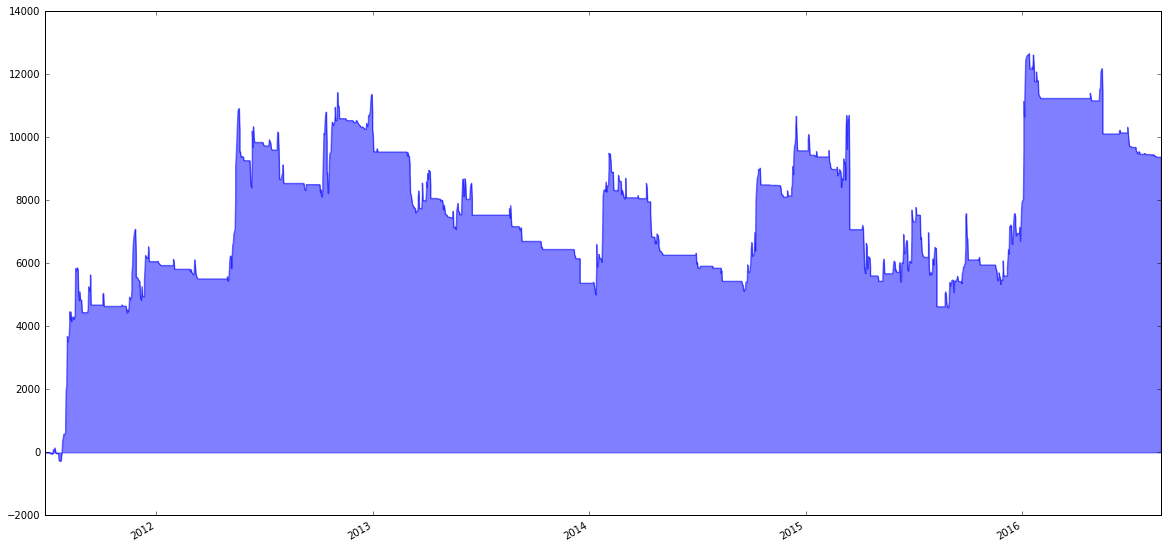

In [548]:
portfolio_stats(best_portfolio, 'Best')

Portfolio name --- Worst(reversed)


PriceChange Mod. Sharpe -0.0157250890654
Netprofit -3704.60567464
Max DD -7139.12035131
Recovery Factor -0.518916265918
Profit factor 0.880960898946
Winrate 13.9934913993


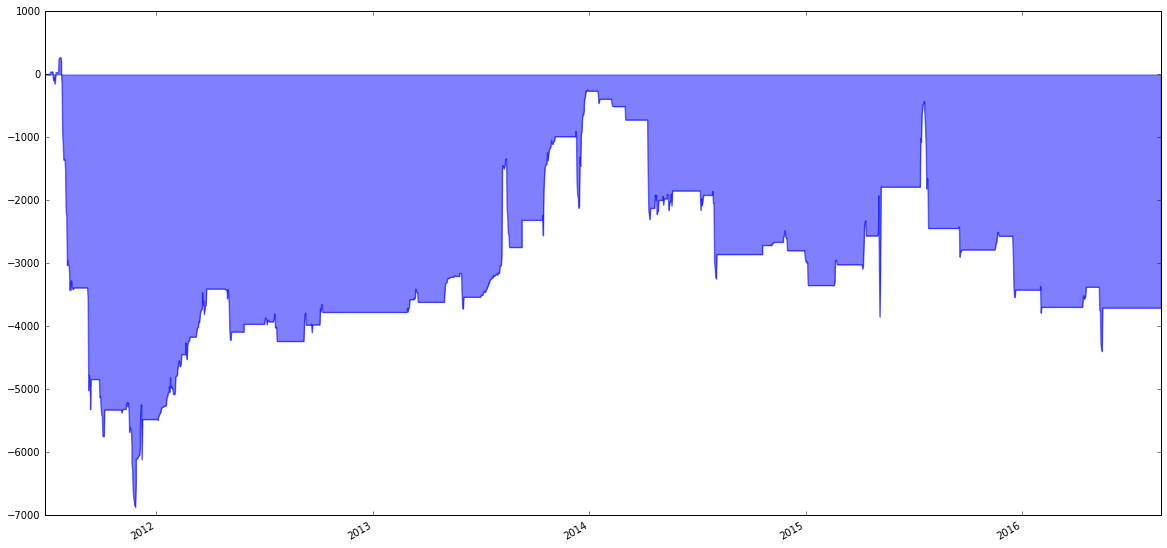

In [549]:
portfolio_stats(worst_portfolio, 'Worst(reversed)')

Portfolio name --- Summary(Best + Worst)


PriceChange Mod. Sharpe 0.0122164595197
Netprofit 5672.58483191
Max DD -7520.76965824
Recovery Factor 0.754255892639
Profit factor 1.06413222224
Winrate 25.3835425384


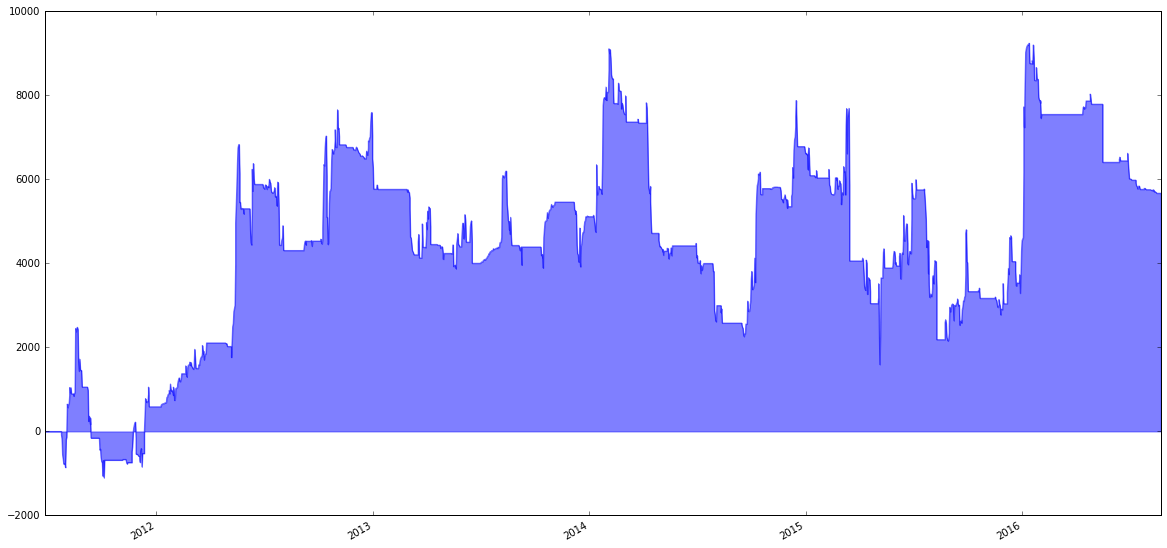

In [550]:
portfolio_stats(summary_portfolio, 'Summary(Best + Worst)')

Portfolio name --- Benchmark(Trade all strategies)


PriceChange Mod. Sharpe 0.0282325960276
Netprofit 30918.3912574
Max DD -21861.0166488
Recovery Factor 1.41431625775
Profit factor 1.15033680377
Winrate 26.5922826592


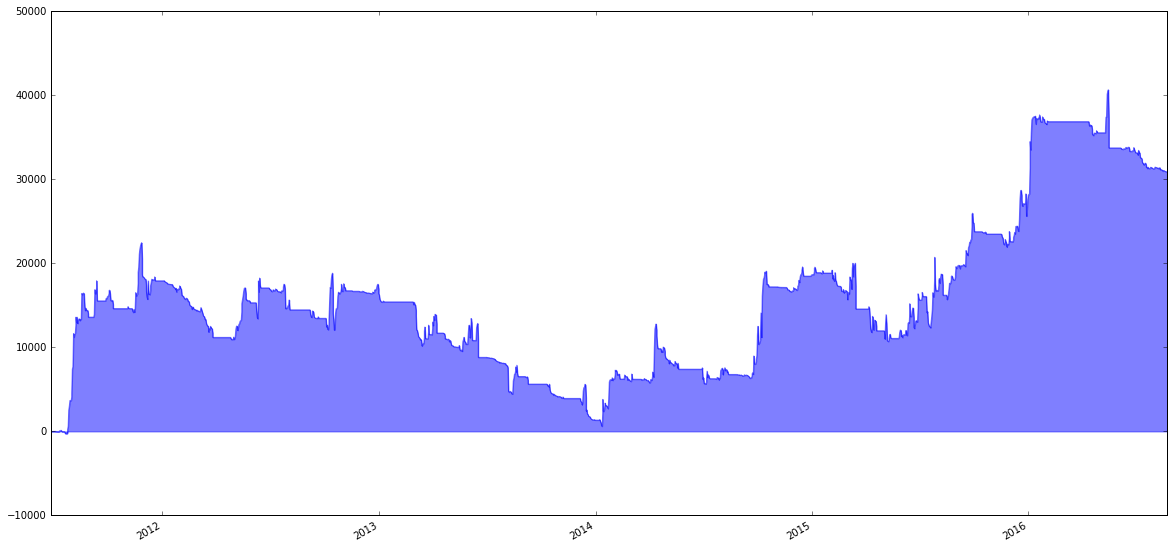

In [551]:
portfolio_stats(benchmark_portfolio, 'Benchmark(Trade all strategies)')

In [ ]:
portfolio_stats(swarm.picked_equity, 'Picked swarm with current approach')